In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy as sa
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
inspector = inspect(engine)
inspector.get_table_names() 

['measurement', 'station']

In [8]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Save references to each table
Station = base.classes.station
Measurement = base.classes.measurement

In [11]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 <a list of 7 Text major ticklabel objects>)

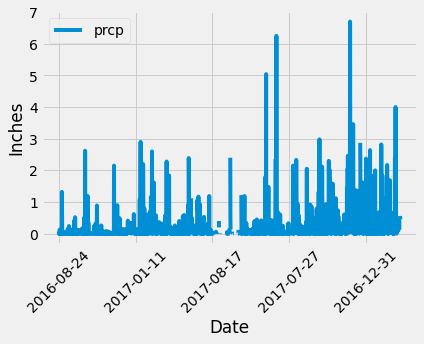

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
year
# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > year).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(data)
df.set_index('date', inplace=True)
# Sort the dataframe by date
df.sort_values('date')
# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=45)


In [49]:
# Use Pandas to calcualte the summary statistics for the precipitation data
statistics = df.groupby(['date'])['prcp'].describe()
statistics

,count,mean,std,min,25%,50%,75%,max
date,,,,,,,,
2016-08-24,6.0,1.555000,0.840541,0.08,1.2775,1.800,2.1500,2.28
2016-08-25,7.0,0.077143,0.071813,0.00,0.0300,0.080,0.0950,0.21
2016-08-26,6.0,0.016667,0.016330,0.00,0.0025,0.015,0.0275,0.04
2016-08-27,5.0,0.064000,0.081731,0.00,0.0000,0.020,0.1200,0.18
2016-08-28,6.0,0.516667,0.787672,0.01,0.1400,0.140,0.4850,2.07
...,...,...,...,...,...,...,...,...
2017-08-19,3.0,0.030000,0.051962,0.00,0.0000,0.000,0.0450,0.09
2017-08-20,2.0,0.005000,0.007071,0.00,0.0025,0.005,0.0075,0.01
2017-08-21,3.0,0.193333,0.317700,0.00,0.0100,0.020,0.2900,0.56


In [57]:
# Design a query to show how many stations are available in this dataset?
# stations = engine.execute(SELECT DISTINCT `station` FROM `Measurement`)
# stations
stations = session.query(Measurement.station).distinct().all()
stations

[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [58]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

station_info = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()
station_info

[(54.0, 85.0, 71.66378066378067)]

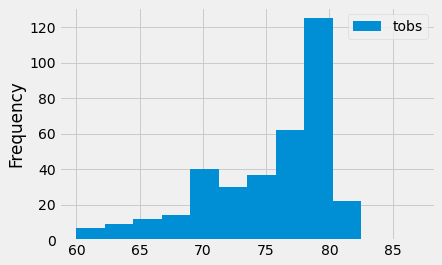

In [32]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_temp = session.query(Measurement.station, func.max(Measurement.tobs)).all()
highest_temp
last_months = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519397').filter(Measurement.date > year).all()
last_months_df = pd.DataFrame(last_months)
last_months_df.plot.hist(bins=12)
plt.xlabel = 'Temperature'
plt.ylabel = 'Frequency'

## Bonus Challenge Assignment

In [33]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [34]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print(calc_temps('2016-09-04', '2016-09-09'))

[(73.0, 77.4054054054054, 84.0)]


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x = 
plt.

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
